## BOXO chemical kinetics model

A simple ODE model for modeling a chemical reaction $A \rightarrow B \rightarrow C$, see https://mjlaine.github.io/mcmcstat/ex/boxoex.html.

In [1]:
import numpy as np
import pandas as pd
from thetafit import Parameter, optimize, sample
from thetafit.utils import McmcOptions, jacob
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
datas = [
    {
        'time': np.array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
        'A': np.array([1.000, 0.504, 0.186, 0.218, 0.022, 0.102, 0.058, 0.064, 0.000, 0.082]),
        'B': np.array([0.000, 0.416, 0.489, 0.595, 0.506, 0.493, 0.458, 0.394, 0.335, 0.309]),
        'temp': 283.,
        'sig2': 0.01
    },
    {
        'time': np.array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
        'A': np.array([1.000, 0.415, 0.156, 0.196, 0.055, 0.011, 0.000, 0.032, 0.000, 0.079]),
        'B': np.array([0.000, 0.518, 0.613, 0.644, 0.444, 0.435, 0.323, 0.390, 0.149, 0.222]),
        'temp': 313.,
        'sig2': 0.01
    }
]

In [3]:
def boxofun(theta, time, y0, temp):
    
    def boxode(y, t, theta, temp):
        
        A, B = y
        
        R = 8.314
        Tmean = 300.
        
        z  = 1./R *(1./temp-1./Tmean)
        k1 = theta['k1mean'] * np.exp(-theta['e1']*1e6*z)
        k2 = theta['k2mean'] * np.exp(-theta['e2']*1e6*z)

        return [
            - k1 * A,
            k1 * A - k2 * B
        ]
        
    return odeint(boxode, y0, time, args=(theta, temp))

In [4]:
params = [
    Parameter('k1mean', init=1.0, minimum=0),
    Parameter('e1', init=0.01, minimum=0),
    Parameter('k2mean', init=1.0, minimum=0),
    Parameter('e2', init=0.01, minimum=0),
    Parameter('A0_0', init=1.0),
    Parameter('A0_1', init=1.0),
    Parameter('B0_0', init=0.0, target=False),
    Parameter('B0_1', init=0.0, target=False)
]

In [5]:
def boxoss(theta, datas):
    
    ss = 0
    for i, data in enumerate(datas):
        y0 = [theta['A0_{0}'.format(i)], theta['B0_{0}'.format(i)]]
        yi = boxofun(theta, data['time'], y0, data['temp'])
        ss += sum((data['A'] - yi[:,0])**2 + (data['B'] - yi[:,1])**2)/data['sig2']
        
    return ss

In [6]:
thopt, res = optimize(boxoss, datas, params, method='Nelder-Mead')

/home/solant/.leanheat-ic/conda/envs/thetafit/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


In [7]:
thopt

{'k1mean': 0.7326479569326174,
 'e1': 0.007601218604112645,
 'k2mean': 0.19695758966665616,
 'e2': 0.006684277134862728,
 'A0_0': 0.946576339857075,
 'A0_1': 1.0013310602762333,
 'B0_0': 0.0,
 'B0_1': 0.0}

In [8]:
mse = 0.01*res.fun/(4*len(datas[0]['A'])-6)
datas[0]['sig2'] = mse
datas[1]['sig2'] = mse

In [9]:
qcov = np.diag((0.05*np.abs(res.x))**2)
options = McmcOptions(nsimu=10000, qcov=qcov, adaptint=100, printint=500)

results, chain, sschain = sample(boxoss, datas, params, options)

Sampling these parameters:
name	start	[min,max]
k1mean	1.0	[0,inf]
e1	0.01	[0,inf]
k2mean	1.0	[0,inf]
e2	0.01	[0,inf]
A0_0	1.0	[-inf,inf]
A0_1	1.0	[-inf,inf]
i: 500, rejected: 85.8%, out of bounds: 16.4%
i: 1000, rejected: 91.4%, out of bounds: 18.7%
i: 1500, rejected: 93.1%, out of bounds: 18.3%
i: 2000, rejected: 94.0%, out of bounds: 18.8%
i: 2500, rejected: 94.8%, out of bounds: 18.8%
i: 3000, rejected: 95.4%, out of bounds: 18.1%
i: 3500, rejected: 95.7%, out of bounds: 18.4%
i: 4000, rejected: 95.9%, out of bounds: 17.3%
i: 4500, rejected: 96.0%, out of bounds: 17.4%
i: 5000, rejected: 96.1%, out of bounds: 16.7%
i: 5500, rejected: 96.0%, out of bounds: 16.1%
i: 6000, rejected: 95.9%, out of bounds: 15.7%
i: 6500, rejected: 95.9%, out of bounds: 15.0%
i: 7000, rejected: 96.0%, out of bounds: 14.3%
i: 7500, rejected: 96.0%, out of bounds: 14.2%
i: 8000, rejected: 95.9%, out of bounds: 13.8%
i: 8500, rejected: 95.8%, out of bounds: 13.7%
i: 9000, rejected: 95.5%, out of bounds: 13.

<IPython.core.display.Javascript object>


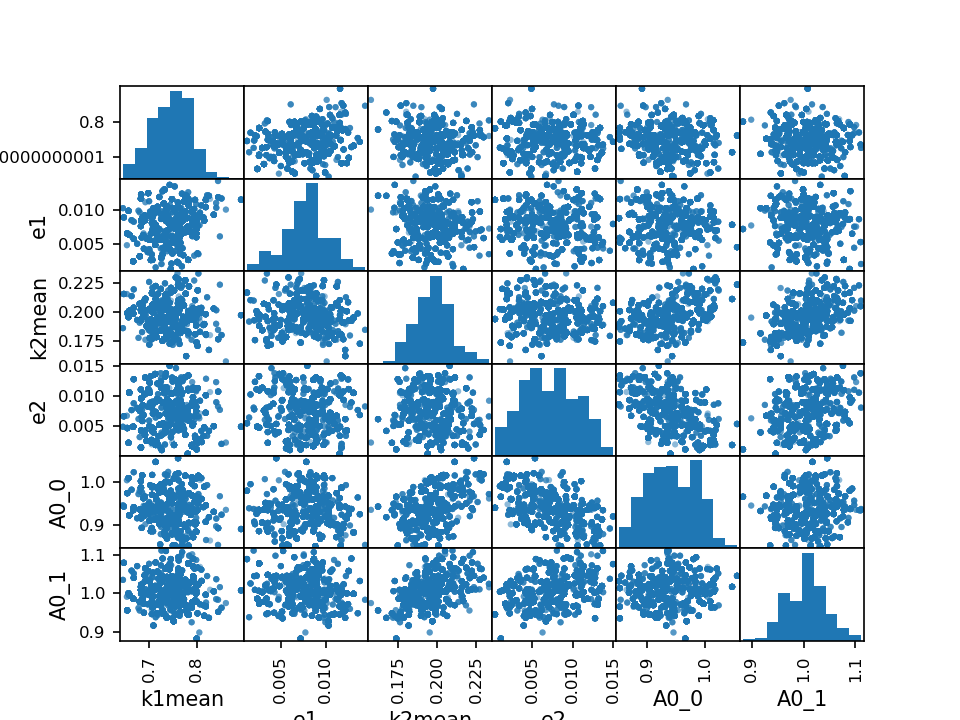

In [10]:
sampled_pars = [par.name for par in params if par.target]
pd.plotting.scatter_matrix(chain[sampled_pars][5000:]);

In [11]:
results

{'N': 10000,
 'accepted': 4.49,
 'rejected': 95.50999999999999,
 'out_of_bounds': 13.389999999999999,
 'qcov': array([[ 1.78501232e-03,  4.19750294e-05, -2.55155708e-05,
          1.26202004e-05, -2.55501535e-04, -1.79446732e-04],
        [ 4.19750294e-05,  8.45232218e-06,  4.35975064e-06,
          2.32637584e-06, -2.27896778e-05,  5.38688430e-06],
        [-2.55155708e-05,  4.35975064e-06,  5.04011098e-03,
          3.80183100e-06,  1.84893683e-03,  1.59381098e-03],
        [ 1.26202004e-05,  2.32637584e-06,  3.80183100e-06,
          1.31107322e-05, -8.70458523e-05,  7.76453699e-05],
        [-2.55501535e-04, -2.27896778e-05,  1.84893683e-03,
         -8.70458523e-05,  2.51155993e-03,  5.43941865e-04],
        [-1.79446732e-04,  5.38688430e-06,  1.59381098e-03,
          7.76453699e-05,  5.43941865e-04,  2.49185617e-03]]),
 'last': array([0.71316192, 0.00152286, 0.19177709, 0.00639659, 0.93969337,
        0.93850584])}